The below problem is one of the introductory modeling practice examples offered by Gurobi - Jupyter Modeling Examples.

The problem description and the majority of codes and schematics are directly from the source. However, some of the comments within the main text here are written by myself.

I took an optimization course called "Deterministic Optimization"[(course description link)](https://catalog.gatech.edu/search/?P=ISYE%206669) from Georgia Tech from professor Renato Monteiro as part of MS in Operations Research program [(program description link)](https://www.isye.gatech.edu/academics/masters/degrees/ms-operations-research) in the fall of 2024. I successfully finished the course and received an A. This is to review the concepts that I studied and to learn how to implement them in python codes using gurobipy.

Copyright © 2023 Gurobi Optimization, LLC

# Text Dissimilarity using Linear Programming

In this notebook, we will walk-through a unique example demonstrating how you can apply optimization to assess text dissimilarity. There are numerous potential applications such as in detecting plagiarism, information retrieval, clustering, text categorization, topic detection, question answer session, machine translation and text summarization. Read here for [more](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=1aff7b429f99f529228a4299a5794971adeb1ca3#:~:text=There%20are%20several%20applications%20or,machine%20translation%2C%20text%20summarization%20etc).

The **Word Mover's Distance** (WMD) is a popular measure of text similarity, which measures the semantic distance between two documents. In this notebook, we will achieve two goals:
- Given two text passages, model WMD as an optimization problem and compute it
- Examine a plagiarized passage from a book, then find the original passage in that book that has the closest semantic meaning to the given passage


|<img src="https://raw.githubusercontent.com/Gurobi/modeling-examples/master/text_dissimilarity/figure_obama.png" width="500" align="center">| 
|:--:|
|An illustration of Word Movers' Distance to measure the similarity between two documents. <b>Image Credits: [Towards AI](https://towardsai.net/p/nlp/word-movers-distance-wmd-explained-an-effective-method-of-document-classification-89cb258401f4) </b>| 

## I. The data

### Google Word-to-Vector Data

In order to find the semantic distance between words, we start by constructing a vector embedding for each word.
For this, we use the popular 'word2vec' dataset from Google News. This dataset has vector embeddings that are pre-trained for 3 million words. Read more about the dataset [here](https://code.google.com/archive/p/word2vec/).

We now import all the packages needed and download the word2vec data. Note that in the code below, downloading the data takes up to a minute. 

In [1]:
# %pip install gensim

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt   
from gensim.models import KeyedVectors 
from scipy import spatial

import gensim.downloader as api
model = api.load('word2vec-google-news-300')

We have downloaded the massive dataset of word-vector embeddings. For example, the embedding of the word "Sherlock' is given below, in a 300-dimension space.

In [3]:
model['Sherlock']

array([-0.00646973,  0.04882812, -0.10205078,  0.1328125 , -0.01855469,
       -0.10253906, -0.10693359,  0.01556396,  0.22949219,  0.06054688,
       -0.02392578,  0.09912109, -0.04541016, -0.01965332, -0.01202393,
        0.04370117,  0.046875  , -0.16210938, -0.02453613, -0.16894531,
       -0.03662109, -0.21289062,  0.25      , -0.06396484,  0.25195312,
        0.31054688,  0.0145874 ,  0.18945312, -0.02233887,  0.0072937 ,
       -0.328125  , -0.20703125, -0.01586914,  0.09033203, -0.06347656,
       -0.07470703, -0.12255859,  0.23046875, -0.06835938,  0.09179688,
        0.07861328, -0.11669922,  0.078125  ,  0.2734375 ,  0.078125  ,
       -0.03808594, -0.02685547,  0.203125  ,  0.1640625 ,  0.14941406,
       -0.11279297,  0.01977539, -0.19238281,  0.10302734,  0.08642578,
       -0.20214844,  0.06738281, -0.25585938, -0.15527344,  0.05493164,
       -0.00915527,  0.24121094,  0.04638672,  0.02453613, -0.22265625,
       -0.10644531, -0.30273438,  0.01446533, -0.24414062,  0.04

The word, 'Sherlock' is embedded in the vector space as above.

**Note. Node Embedding** \
*credit: Georgia Tech ISYE 6740 Computational Data Analysis by Prof. Kai Wang, Lecture Note "PageRank & Graph Embedding" page 13 to 37, Fall 2024*


Think of a graph with millions of nodes representing words. What word2vec does is embed each node into an $d$-dimensional space, where $d$ is the number of features for each word (or node). The goal is to approximate the similarity (e.g., Euclidean distance or dot product) in the embedding space to the similarity observed in the graph.

In graph-based contexts, random walk similarity is often used for its computational efficiency. A random walk involves starting at a node $u$ and moving to a neighboring node at each step according to a predefined probability distribution (e.g., uniform or weighted by edge weights). The random walk similarity between two nodes $u$ and $v$ can be defined as the probability that node $v$ co-occurs with node $u$ in random walks over the graph.

We can represent our goal as below. The negative log-likelihood objective (NLL) is as follows. We attempt to minimize $\mathcal{L}$ with stochastic gradient descent method.

* $u$, $v$              : nodes
* $V$                   : set of nodes
* $N_R{(u)}$            : set of neighboring nodes to $u$
* $P(N_R{(u)}\:|\:z_u)$ : probability of each node in $N_R{(u)}$ co-occuring in the same random walk with node $u$
* $P(v \:|\:z_u)$       : probability of each node $v$ in $N_R{(u)}$ occuring in the same random walk with node $u$
* $z_u$                 : embedded node vector in space $R$


\begin{align*}
\mathcal{L} &= - \sum_{u \in V} \log{P(N_R(u) \:|\: z_u)} \\
            &= - \sum_{u \in V} \sum_{v \in N_R{(u)}} \log{P(v \:|\: z_u)} \\
            &= - \sum_{u \in V} \sum_{v \in N_R{(u)}} \log{\frac{\exp{(z_u^\top z_v)}}{\exp{\sum_{v' \in V}(z_u^\top z_{v'})}}} \quad \text{(softmax representation)} \\
            &\approx \log(\sigma(z_u^\top z_v)) - \sum_{i = 1}^k \log(\sigma(z_u^\top z_{n_i}))\\
            &\text{where } \sigma(x) = \frac{1}{1 + e^{-x}} \text{ ,  } n_i \sim P_V \text{  ($n_i$'s are random samples from a suitable distribution, $P_V$)}
\end{align*}

The approximation in the last part is actually a different objective. However, it is known to approximately maximize the log probability (or minimize the negative log probability) of softmax.

The resultant algorithm goes like this:

1. Random sample a node $u$ from the graph
2. Randomly generate some random walks, $N_R{(u)}$  and $k$ negative samples $\{n_i \sim P_V\}_{i\in[k]}$ 
   - k-samples are from nodes that are not connected to node $u$
   - As can be seen in the NLL specification above, if nodes from $N_R{(u)}$ are embedded as vectors close to $z_u$, $\mathcal{L}$ becomes smaller
   - On the other hand, if the $k$-nodes, which are not connected to $u$, are embedded as vectors far from $z_u$, $\mathcal{L}$ becomes smaller
   - In this way, the model embeds neighboring nodes' vectors close to each other and non-neighboring nodes' vectors far apart, effectively approximating the similarity in the graph within the vector space.
3. Construct the NLL (NLL loss of node $u$). Specification is shown above.
4. For all $j$, find $z_j$ by running SGD for the minimization problem.

### Enter two documents 

Next, we create the two documents to compare. In this example we look at a sentence from Sir Arthur Conan Doyle’s *The Adventures of Sherlock Holmes* (the original literary data-driven detective): 

"The little man stood glancing from one to the other of us with half-frightened, half-hopeful eyes, as one who is not sure whether he is on the verge of a windfall or of a catastrophe."


We use a popular text generation technology ([ChatGPT](https://chat.openai.com/chat)) to construct semantically similar sentence. 

<img src="https://raw.githubusercontent.com/Gurobi/modeling-examples/master/text_dissimilarity/chatgpt clip.gif" width="750" align="center">


We store the two sentences (documents) as strings. You can try other pairs of sentences too. Some are given in the commented text below.

In [4]:
document1 = 'The little man stood glancing from one to the other of us with half-frightened, half-hopeful eyes, as one who is not sure whether he is on the verge of a windfall or of a catastrophe.'
document2 = 'With a gaze that shifted back and forth between us, the diminutive figure appeared to be a mixture of apprehension and anticipation, uncertain if he was on the cusp of a fortune or a disaster.'

# document1 = 'I barely saw Sherlock recently.'
# document2 = 'Lately, I have had little opportunity to catch a glimpse of Sherlock.'

# document1 = 'Obama speaks to the media in Illinois.'
# document2 = 'The President greets the press in Chicago'

##  II. Pre-processing the text

Before comparing the two documents, we first eliminate certain words that may not carry any semantic value, for example, prepositions (e.g., in, on, under), conjunctions (e.g., and, for, but), and determiners (e.g., a, an, the, another). These words are called **stop words**. Read more [here](https://kavita-ganesan.com/what-are-stop-words/#.ZCCurezMLt0).
We also remove punctuation marks and proper nouns, and then we convert all the words to their lower-case equivalents.

We use the nltk package to ensure this. In the code below, the lines with "nltk.download" need to be executed the first time this notebook is run. You may comment the lines for subsequent runs.

In [5]:
# %pip install nltk

In [6]:
import nltk 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')  
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import PorterStemmer 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jhkan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jhkan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jhkan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Split each document into words (or "tags"). Each word is classified into several categories. For example, 'NN' corresponds to a singular noun and 'VBD' is a verb in the past tense. See [here](https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/) for the complete list of classifications. 

In [7]:
tagged_doc1 = nltk.tag.pos_tag(document1.split())
tagged_doc2 = nltk.tag.pos_tag(document2.split()) 
print(tagged_doc1)
print(tagged_doc2) 

[('The', 'DT'), ('little', 'JJ'), ('man', 'NN'), ('stood', 'VBD'), ('glancing', 'VBG'), ('from', 'IN'), ('one', 'CD'), ('to', 'TO'), ('the', 'DT'), ('other', 'JJ'), ('of', 'IN'), ('us', 'PRP'), ('with', 'IN'), ('half-frightened,', 'JJ'), ('half-hopeful', 'JJ'), ('eyes,', 'NN'), ('as', 'IN'), ('one', 'CD'), ('who', 'WP'), ('is', 'VBZ'), ('not', 'RB'), ('sure', 'JJ'), ('whether', 'IN'), ('he', 'PRP'), ('is', 'VBZ'), ('on', 'IN'), ('the', 'DT'), ('verge', 'NN'), ('of', 'IN'), ('a', 'DT'), ('windfall', 'NN'), ('or', 'CC'), ('of', 'IN'), ('a', 'DT'), ('catastrophe.', 'NN')]
[('With', 'IN'), ('a', 'DT'), ('gaze', 'NN'), ('that', 'WDT'), ('shifted', 'VBD'), ('back', 'RB'), ('and', 'CC'), ('forth', 'NN'), ('between', 'IN'), ('us,', 'JJ'), ('the', 'DT'), ('diminutive', 'JJ'), ('figure', 'NN'), ('appeared', 'VBD'), ('to', 'TO'), ('be', 'VB'), ('a', 'DT'), ('mixture', 'NN'), ('of', 'IN'), ('apprehension', 'NN'), ('and', 'CC'), ('anticipation,', 'NN'), ('uncertain', 'RB'), ('if', 'IN'), ('he', 'PR

Knowing the categories, we first remove the proper nouns, given by the classification NNP (for singular proper nouns) and NNPS (for plural proper nouns).

In [8]:
edited_sentence1 = [word for word,tag in tagged_doc1 if tag not in ['NNP','NNPS']]
edited_sentence2 = [word for word,tag in tagged_doc2 if tag not in ['NNP','NNPS']] 
print(edited_sentence1)
print(edited_sentence2) 

['The', 'little', 'man', 'stood', 'glancing', 'from', 'one', 'to', 'the', 'other', 'of', 'us', 'with', 'half-frightened,', 'half-hopeful', 'eyes,', 'as', 'one', 'who', 'is', 'not', 'sure', 'whether', 'he', 'is', 'on', 'the', 'verge', 'of', 'a', 'windfall', 'or', 'of', 'a', 'catastrophe.']
['With', 'a', 'gaze', 'that', 'shifted', 'back', 'and', 'forth', 'between', 'us,', 'the', 'diminutive', 'figure', 'appeared', 'to', 'be', 'a', 'mixture', 'of', 'apprehension', 'and', 'anticipation,', 'uncertain', 'if', 'he', 'was', 'on', 'the', 'cusp', 'of', 'a', 'fortune', 'or', 'a', 'disaster.']


Next, we remove all the punctuation marks.

In [9]:
tokenizer = RegexpTokenizer(r'\w+') 
processed_doc1 = tokenizer.tokenize(' '.join(edited_sentence1))
processed_doc2 = tokenizer.tokenize(' '.join(edited_sentence2))
print(processed_doc1)
print(processed_doc2) 

['The', 'little', 'man', 'stood', 'glancing', 'from', 'one', 'to', 'the', 'other', 'of', 'us', 'with', 'half', 'frightened', 'half', 'hopeful', 'eyes', 'as', 'one', 'who', 'is', 'not', 'sure', 'whether', 'he', 'is', 'on', 'the', 'verge', 'of', 'a', 'windfall', 'or', 'of', 'a', 'catastrophe']
['With', 'a', 'gaze', 'that', 'shifted', 'back', 'and', 'forth', 'between', 'us', 'the', 'diminutive', 'figure', 'appeared', 'to', 'be', 'a', 'mixture', 'of', 'apprehension', 'and', 'anticipation', 'uncertain', 'if', 'he', 'was', 'on', 'the', 'cusp', 'of', 'a', 'fortune', 'or', 'a', 'disaster']


We now remove all the stop words.

In [10]:
processed_doc1 = [x.lower() for x in processed_doc1]
processed_doc2 = [x.lower() for x in processed_doc2]
processed_doc1 = [i for i in processed_doc1 if i not in stopwords.words('english')]
processed_doc2 = [i for i in processed_doc2 if i not in stopwords.words('english')]

print(processed_doc1,'\n', processed_doc2) 

['little', 'man', 'stood', 'glancing', 'one', 'us', 'half', 'frightened', 'half', 'hopeful', 'eyes', 'one', 'sure', 'whether', 'verge', 'windfall', 'catastrophe'] 
 ['gaze', 'shifted', 'back', 'forth', 'us', 'diminutive', 'figure', 'appeared', 'mixture', 'apprehension', 'anticipation', 'uncertain', 'cusp', 'fortune', 'disaster']


For a better visualization of the processed documents, let us create word clouds out of them.

In [11]:
# %pip install wordcloud

Document 1:


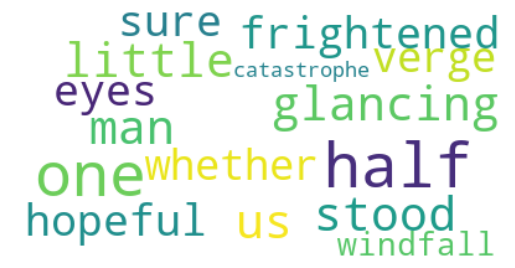

Document 2:


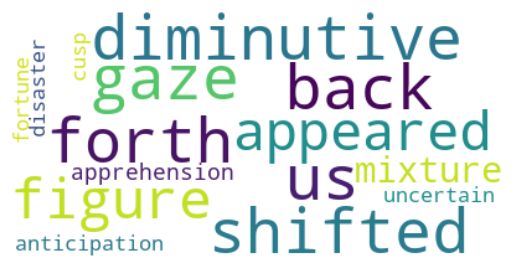

In [12]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

print("Document 1:") 
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(processed_doc1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("Document 2:")
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(processed_doc2))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

To prepare the documents for the optimization model, let us store the frequency of occurrences of each word.

In [13]:
freqency_D1 = {i: processed_doc1.count(i)/len(processed_doc1) for i in processed_doc1}
freqency_D2 = {i: processed_doc2.count(i)/len(processed_doc2) for i in processed_doc2}

D1 = set(processed_doc1)
D2 = set(processed_doc2) 
print(D1,D2)

{'eyes', 'us', 'sure', 'windfall', 'whether', 'verge', 'catastrophe', 'man', 'hopeful', 'frightened', 'glancing', 'little', 'half', 'stood', 'one'} {'anticipation', 'diminutive', 'back', 'gaze', 'cusp', 'appeared', 'apprehension', 'disaster', 'forth', 'fortune', 'figure', 'uncertain', 'mixture', 'shifted', 'us'}


We now get the word-to-word distance matrix. Given the vector embeddings of two words $\overline{x}_1$ and $\overline{x}_2$, we take the cosine distance between them given by, $\overline{x}_1 . \overline{x}_2$/$|\overline{x}_1||\overline{x}_2|$.

In [14]:
import numpy as np

distance = {(i, j): spatial.distance.cosine(model[i], model[j]) for i in D1 for j in D2}

The code below shows the sorted distances between all pairs of words in the two documents.

The code below shows the sorted distances between all pairs of words in the two documents.

In [15]:
# pandas review

# distance.items() # returns key-value pairs # ((i, j), cosine of the two embedded vectors)
# key = xx # key parameter states the sorting criteria
# lambda item: item[1] # lambda function takes "item" and returns "items[1]" #here, item is the key-value pairs and item[1] is "value", i.e., cosine
# therefore sorts the key-value pairs in terms of cosine
# dict() # take the sorted key-value pairs and make them dictionary

In [16]:
 dict(sorted(distance.items(), key=lambda item: item[1]))

{('us', 'us'): 0.0,
 ('verge', 'cusp'): 0.20255764914764973,
 ('catastrophe', 'disaster'): 0.26837605738876014,
 ('eyes', 'gaze'): 0.40868104822045936,
 ('glancing', 'gaze'): 0.4709460773345311,
 ('windfall', 'fortune'): 0.5083202313882496,
 ('hopeful', 'uncertain'): 0.5853803700854052,
 ('stood', 'appeared'): 0.6904836809016344,
 ('whether', 'uncertain'): 0.6907485065144767,
 ('one', 'us'): 0.7060850513307896,
 ('little', 'us'): 0.7092129498407855,
 ('us', 'back'): 0.7105296933963319,
 ('hopeful', 'cusp'): 0.7111398756967413,
 ('sure', 'us'): 0.71219912197038,
 ('glancing', 'appeared'): 0.7124004741679594,
 ('little', 'back'): 0.724949669701757,
 ('sure', 'back'): 0.7252470774307309,
 ('stood', 'gaze'): 0.7294918300166416,
 ('frightened', 'apprehension'): 0.7306801264972707,
 ('frightened', 'uncertain'): 0.7403901791414207,
 ('little', 'mixture'): 0.7446245946769683,
 ('half', 'back'): 0.7597489369076549,
 ('glancing', 'diminutive'): 0.7725773645791751,
 ('one', 'figure'): 0.774103474

**Note.** In short, by leveraging `nltk` package, we could embed words of our interest into vector space, calculate their frequency and distances among themselves.

## III. Computing text dissimilarity using a linear program

Now, we model the Word Mover's Distance (WMD) as an optimization problem.
The idea is to send *flow* from the words in document 1 to the words in document 2 in such a way that the product of the distance and flow is minimized.
In other words, we send higher flow between words that have a smaller distance, and hence, are semantically closer to each other.

In the figure below, we see how the optimal flow corresponds to pairs of words that are semantically the closest.

|<img src="https://raw.githubusercontent.com/Gurobi/modeling-examples/master/text_dissimilarity/figure_obama2.png" width="500" align="center">| 
|:--:|
|An illustration of Word Movers' Distance to measure the similarity between two documents. <b>Image Credits: [Towards AI](https://towardsai.net/p/nlp/word-movers-distance-wmd-explained-an-effective-method-of-document-classification-89cb258401f4) </b>| 

<!-- The score: weighted sum of distances. -->

In optimization terminology, this model is famously called the **transportation model**, where the flow corresponds to transporting commodities between locations (such as warehouse and retail locations). 


Before we build the model, we first define the input parameters.

### Input Parameters

$D_1, D_2$: two documents each representing a set of words,

$p_w$: frequency of word $w$ in $D_1$,

$q_{w'}$: frequency of word $w'$ in $D_2$,

$d(w,w')$: distance between word embeddings of $w$ and $w'$.

To build the model, we initiate the Gurobi model.

In [17]:
import gurobipy as gp
from gurobipy import GRB

In [18]:
# Initialize the model
m = gp.Model("Text_Similarity")

Set parameter Username


### Objective: Minimize the net distance times flow 

The higher the flow, the more semantically close those words are expected to be. This is achieved by defining the objective function to be the product of the distance and the flow, mathematically expressed as:

Minimizing this objective naturally allocates higher flow values to word-pairs that have a smaller distance. 

### Flow variables

The following is the key decision variable in the model.

$f_{w,w'}$: Amount of flow from word $w$ in $D_1$ to word $w'$ in $D_2$.



We can add the flow variables for all pairs of words using the addVars function. We allow the flow variable to be between $0$ and $1$, and hence set the lower bound (lb) to $0$ and the upper bound (ub) to $1$.

### Constraints


Finally, we define constraints to ensure that each word has a representation in the flow proportional to its frequency of occurrence.
We do this by ensuring: the net flow exiting from each word $w$ in document $D_1$ is equal to its frequency of occurrence in $D_1$.
Similarly, the net flow entering each word $w'$ in document $D_2$ is equal to its frequency of occurrence in $D_2$.
These two constraints can be expressed by the following two equations.

**Note.**
Think of it as a probelm similar to Assignement Problem.

One one hand, there are nodes representing words from document 1. The other end are nodes of words from document 2.
There are in total $|D1| * |D2|$ arcs. Here, distances are costs; hence there is incentive to assign greater amounts of flow to smaller distance arcs. Note that distances are already calculated by *word2vec* and given as constants in the optimization probelm.
The amount of frequency works as an upper limit of flow for each node. Total outflows from words from document 1 equals 1 as well as total inflows into words from document 2.


\begin{aligned}
\textrm{minimize} &\sum_{w \in D_1} \sum_{w' \in D_2}  d(w,w') f_{w,w'} \\
\textrm{s.t.} &\sum_{w' \in D_2} f_{w,w'} = p_w \quad  \forall \ w \in D_1, \\
\ &\sum_{w \in D_1} f_{w,w'} = q_{w'} \quad  \forall  \ w' \in D_2
\end{aligned}


In [19]:
# python pandas review
# when key is a tuple
# distance[w, w_prime] is equal to distance[(w, w_prime)]

In [20]:
# flow variable # f[w1, w2] ...
f = m.addVars(D1, D2, name = 'f', lb = 0, ub = 1)

# objective function
m.ModelSense = GRB.MINIMIZE
m.setObjective(sum(f[w, w_prime] * distance[w, w_prime] for w in D1 for w_prime in D2))
m.update()

# constraints
m.addConstrs(sum(f[w, w_prime] for w_prime in D2) == freqency_D1[w] for w in D1)
m.addConstrs(sum(f[w, w_prime] for w in D1) == freqency_D2[w_prime] for w_prime in D2)
#in gurobipy
#m.addConstrs(f.sum(w, '*') == freqency_D1[w] for w in D1)
#m.addConstrs(f.sum('*', w_prime) == freqency_D2[w_prime] for w_prime in D2)
m.update()

### Solve the model

In [21]:
m.optimize()  

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 30 rows, 225 columns and 450 nonzeros
Model fingerprint: 0xbfd73ae9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 1e-01]
Presolve time: 0.01s
Presolved: 30 rows, 225 columns, 450 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7110992e-01   8.627451e-01   0.000000e+00      0s
      25    6.2717735e-01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.02 seconds (0.00 work units)
Optimal objective  6.271773539e-01


#### Visualize the optimal solution

In [22]:
print('Dissmiliarity score', round(m.ObjVal, 2))

Dissmiliarity score 0.63


In [23]:
flow = {(i, j): f[i, j].X for i in D1 for j in D2} # objective solution # dictionary

In [24]:
solution_data = [
    (i, j, flow_val, distance[i, j]) 
    for (i, j), flow_val in flow.items()
]

In [25]:
solution = pd.DataFrame(
    solution_data,
    columns = ['word 1', 'word 2', 'flow', 'distance']
)

The two code blocks are equivalent to below as originally provided by gurobi tutorial material. Below codes run the same for loop for four times unnecessarily.

```python
solution['word 1'] = [i for (i,j) in flow]
solution['word 2'] = [j for (i,j) in flow]
solution['flow'] = [flow[i,j] for (i,j) in flow]
solution['distance'] = [distance[i,j] for (i,j) in flow] 

In [26]:
solution.sort_values(by = 'distance', ascending = True).reset_index(drop = True)

,word 1,word 2,flow,distance
0,us,us,0.058824,0.000000
1,verge,cusp,0.058824,0.202558
2,catastrophe,disaster,0.058824,0.268376
3,eyes,gaze,0.058824,0.408681
4,glancing,gaze,0.007843,0.470946
...,...,...,...,...
220,us,appeared,0.000000,1.026783
221,windfall,forth,0.000000,1.043436
222,man,anticipation,0.000000,1.046994
223,stood,mixture,0.000000,1.054889


**Note.**\
Now we have a way to connect two given documents and compute dissmilarity score. This is a groundwork for detecting plagiarism.

## IV. Detect plagiarism

In this part of the notebook, we check if a given text has been re-written (or plagiarized) from a book. To do this, we compare the given text with every sentence in the book, and output the sentence with the smallest dissimilarity. After that, a human can make the final evaluation of whether this is indeed a case of plagiarism.

First, read the book (The Adventures of Sherlock Holmes) as a text file. We downloaded the file from [Project Gutenberg](https://www.gutenberg.org/cache/epub/1661/pg1661.txt).

In [27]:
import base64
import requests

In [28]:
master = "https://raw.githubusercontent.com/Gurobi/modeling-examples/master/text_dissimilarity/PG1661_raw.txt"
content = requests.get(master)
content = content.text
content = content.replace('\n',' ')
content = content.replace('_',' ')
content = content.replace('\r','') 
sentences = list(map(str.strip, content.split(".")))[19:]

Pre-process all the sentences in the book.

In [29]:
def pre_processing(document):
    # Remove proper nouns
    tagged_doc = nltk.tag.pos_tag(document.split())
    edited_sentence = [word for word,tag in tagged_doc]  
    edited_sentence = [word for word,tag in tagged_doc if tag not in ['NNP','NNPS']]  

    # Remove punctuation 
    tokenizer = RegexpTokenizer(r'\w+') 
    processed_doc = tokenizer.tokenize(' '.join(edited_sentence)) 

    # Remove stop words 
    processed_doc = [i for i in processed_doc if i not in stopwords.words('english')]  
    
    return processed_doc

processed_sentences = [] # list of all sentences
for s in sentences: 
    processed_sentences.append(pre_processing(s))


We can write the WMD optimization model within a function that inputs two documents, and outputs their dissimilairty score.

In [30]:
def score_dissimilarity(D1, D2):
    # set of words
    D1 = set(D1)
    D2 = set(D2) 
    
    # to exclude words not in the word2vec data
    D1 = D1 - set([i for i in D1 if i not in model])
    D2 = D2 - set([j for j in D2 if j not in model]) 
    
    # dict of {word: freq}
    freq_D1 = {i: list(D1).count(i)/len(D1) for i in D1}
    freq_D2 = {i: list(D2).count(i)/len(D2) for i in D2}

    if len(D2) < 5: # if the sentence is too small, we set a high dissimilarity, effectively ignoring it
        return 1

    # empty model
    m = gp.Model("Text_similarity")

    # distance dict - {word to word arc: distance} 
    distance = {(i,j): spatial.distance.cosine(model[i],model[j]) for i in D1 for j in D2} 

    # flow variable (decision variable)
    f = m.addVars(D1,D2,name="f",lb=0,ub=1) 

    # direction of optimization
    m.ModelSense = GRB.MINIMIZE

    # objective function
    m.setObjective(sum(f[w,w_prime]*distance[w,w_prime] for w in D1 for w_prime in D2))

    # constraints
    m.addConstrs(f.sum(w, '*') ==  freq_D1[w] for w in D1)
    m.addConstrs(f.sum('*', w_prime) == freq_D2[w_prime] for w_prime in D2) 
    # m.addConstrs(sum(f[w, w_prime] for w_prime in D2) == freq_D1[w] for w in D1)
    # m.addConstrs(sum(f[w, w_prime] for w in D1) == freq_D2[w_prime] for w_prime in D2)
    
    # Run
    m.setParam('OutputFlag', 0)
    m.optimize()  
    
    return m.ObjVal

Now, we select a passage that is re-written from the book. The following code has some examples, but feel free to pick any sentence from [the book](https://www.gutenberg.org/cache/epub/1661/pg1661.txt) and create your own plagiarized version.

In [31]:
sample_sentence = 'With a gaze that shifted back and forth between us, the dimunitive figure appeared to be a mixture of apprehension and anticipation, uncertain if he was on the cusp of a fortune or a disaster.'
# sample_sentence = 'Without much conversation, yet with a friendly gesture, he gestured towards an armchair for me to sit in, offered me a box of cigars, and pointed to a liquor cabinet and a carbonated water dispenser in the corner.' 

print(sample_sentence)

With a gaze that shifted back and forth between us, the dimunitive figure appeared to be a mixture of apprehension and anticipation, uncertain if he was on the cusp of a fortune or a disaster.


Finally, we iterate over all the sentences in the book, and find the dissimilairty score. The following code only prints the output whenever the dissimilarity goes down in value. The result is a sentence with the smallest dissimilarity.

In [ ]:
obj_best = 1
print("#\t Dissimilarity\t Sentence")
for i in range(len(processed_sentences)):  
    obj = score_dissimilarity(pre_processing(sample_sentence),processed_sentences[i])  
    if obj < obj_best: 
        print(i,"\t",round((obj),2),"\t",sentences[i])
        obj_best, sentence_best = obj, sentences[i]

print("\nThe closest sentence with a %f dissimilarity is:\n\n"%obj_best,sentence_best) 

#	 Dissimilarity	 Sentence
1 	 0.84 	 I have seldom heard him mention her under any other name
2 	 0.79 	 In his eyes she eclipses and predominates the whole of her sex
3 	 0.79 	 It was not that he felt any emotion akin to love for Irene Adler
8 	 0.77 	 But for the trained reasoner to admit such intrusions into his own delicate and finely adjusted temperament was to introduce a distracting factor which might throw a doubt upon all his mental results
12 	 0.75 	 My marriage had drifted us away from each other
15 	 0.75 	 From time to time I heard some vague account of his doings: of his summons to Odessa in the case of the Trepoff murder, of his clearing up of the singular tragedy of the Atkinson brothers at Trincomalee, and finally of the mission which he had accomplished so delicately and successfully for the reigning family of Holland
19 	 0.72 	 His rooms were brilliantly lit, and, even as I looked up, I saw his tall, spare figure pass twice in a dark silhouette against the blind


Now take a look at the output sentence and compare it with the sample sentence. Do you see plagiarism going on? 

Copyright © 2023 Gurobi Optimization, LLC

### Summary

##### 1. Take two documents to compare, preprocess them (e.g., make all lower cases, remove punctuations)
##### 1.1 Compute frequency of each word in its respective document
##### 1.2 Use 'word2vec' to embed the words into vector space to acquire vector representations, calculate distances of all word pairs
##### 2. Build up minimized cost network flow problem for computing dissmilarity of given two texts
##### 2.1 Objective = total distance minimization where total distance = sumproduct flow and distance (each arc, flow: word1 to word2, cost = distance of the pair)
##### 2.2 Constraints = flow capacities = frequencies (each flow <= 1)
##### From 1 and 2, we can calculate the dissmilarity score of two given texts.